## TVLT Masked Autoencoding

This notebook demonstrates the masked autoencoding in TVLT on video and audio inputs.

### Load model for audio and video reconstruction

In [23]:
%load_ext autoreload
%autoreload 2

from demos import MAE_model
model = MAE_model()

### Load sample data

In [24]:
from model.data.datasets.rawvideo_utils import load_audio, load_video, load_video_audio

video_path = 'demo_samples/Howto100m/mg7Q4o9bNN0.mp4'  # replace your own video (with audio) here
timestamp = [42.0,48.0]  # set the timestamp
num_frames = 1   # set number of frames to sample
video, audio = load_video_audio(video_path, num_frames=1, sr=44100, timestamp=timestamp)

Please take notes about the size of the input video and audio.
* Dimension of input video tensor: (batch_size, number_of_frames, rgb_channel, width, height)  
* Dimension of input audio tensor: (batch_size, number_of_audio_channels, time, spectrogram)

In [25]:
print("Input video tensor size:", video.size())
print("Input audio tensor size:", audio.size())


Input video tensor size: torch.Size([1, 1, 3, 224, 224])
Input audio tensor size: torch.Size([1, 1, 528, 128])


In [26]:
audio_feature_len = 528  # save the length of audio feature (will be used in visualization)

### Inference

In [27]:
_, decoder_audio_outputs, decoder_video_outputs, _, mask_a, mask_v = model(video=video, audio=audio, mask_visual=True, use_mae=True)
pred_v = model.mae_score_video(decoder_video_outputs).detach().numpy() 
pred_a = model.mae_score_audio(decoder_audio_outputs).detach().numpy() 

TVLT will split the input video frame and audio spectrogram into $16\times 16$ patches.  
This will give us $\frac{224}{16} \times \frac{224}{16} = 196$ video patches and $\frac{528}{16} \times \frac{128}{16} = 264$ audio patches.  
Those patch inputs will be feeded to a transformer encoder (768-dimension) and then to a transformer decoder (512-dimension).  
See the size of the output tensors for video and audio.

In [37]:
print("Decoded Video outputs Size:", decoder_video_outputs.size())
print("Decoded Audio outputs Size:", decoder_audio_outputs.size())

Decoded Video outputs Size: torch.Size([1, 196, 512])
Decoded Audio outputs Size: torch.Size([1, 264, 512])


Finally, we would like to recover the original video frame and audio spectrogram.  
For each video frame patch, we will need to recover a total number of $16\times 16 \times 3 = 768$ scalar values.  
For each audio spectrogram patch, will need to recover a total number of $16 \times 16 \times 1 = 256$ scalar values.  

In [36]:
print("reconstructed video tensor Size:", pred_v.shape)
print("reconstructed audio tensor Size:", pred_a.shape)

reconstructed video tensor Size: (1, 196, 768)
reconstructed audio tensor Size: (1, 264, 256)


### Visualize video reconstruction

Original Video Frame


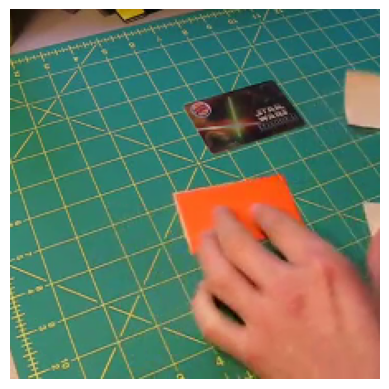

Reconstruction of the Masked Patches of the Frame


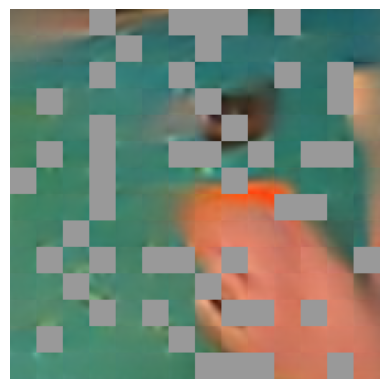

In [41]:
from demos import visualize_video
print('Original Video Frame')
import matplotlib.pyplot as plt
plt.axis('off')
plt.imshow((video.squeeze()/2+0.5).permute(1,2,0).numpy())
plt.show()


print('Reconstruction of the Masked Patches of the Frame')
masked_pred_v = pred_v.copy()
masked_pred_v[~mask_v.bool()] = 0.2
visualize_video(masked_pred_v)

We compare the predicted masked patches with the groudtruth patches and use MSE loss as one of the objectives (we also use contrastive loss) to train TVLT.

You can also use the model to do full reconstruction on the input frame given the masked input.  
See the visual below.

We can also do full reconstruction for all the patches (both masked and unmasked).


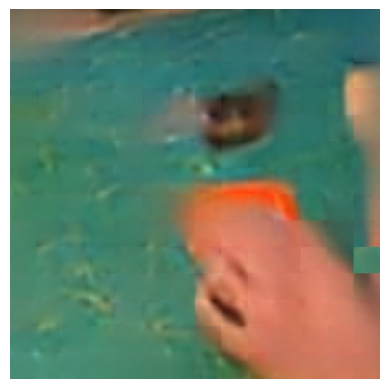

In [40]:
print('We can also do full reconstruction for all the patches (both masked and unmasked).')
visualize_video(pred_v)

### Visualize audio reconstruction

Original Audio Spectrogram


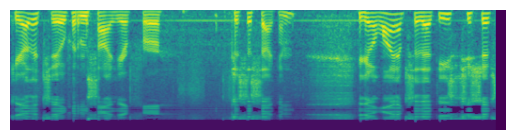

Reconstruction of the Masked Spectrogram


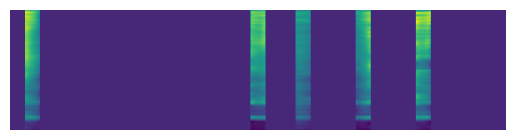

In [43]:
from demos import visualize_audio
print('Original Audio Spectrogram')
import matplotlib.pyplot as plt
plt.axis('off')
plt.imshow((audio.squeeze()/2+0.5).permute(1,0).numpy())
plt.show()


print('Reconstruction of the Masked Spectrogram')
masked_pred_a = pred_a.copy()
masked_pred_a[~mask_a.bool()] = -0.7
visualize_audio(masked_pred_a, audio_len=audio_feature_len)

Similar to video reconstruction, we compare the predicted masked patches with the groudtruth patches and use MSE loss as one of the objectives (we also use contrastive loss) to train TVLT.  

Note that we do "whole word masking" for the audio spectrogram where the whole frequency-axis is masked for detected speeches. Please refer to the [codebase](https://github.com/zinengtang/TVLT/blob/d37de8a8f014940f4f5be0615717c134671f0566/model/modules/tvlt.py#L356) for details about audio masking.

We can also do full reconstruction for all the patches (both masked and unmasked).


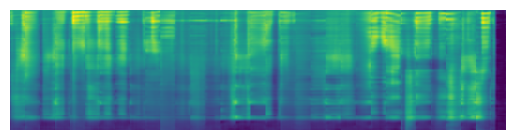

In [44]:
print('We can also do full reconstruction for all the patches (both masked and unmasked).')
visualize_audio(pred_a, audio_len=audio_feature_len)